In [1]:
import collections
import math 
import pandas as pd
import numpy as np
import scipy
from scipy.special import perm, comb # for nPk 
from sympy.functions.combinatorial.numbers import stirling
import matplotlib.pyplot as plt 
pd.set_option('precision', 10)
%matplotlib inline


Bad key text.latex.unicode in file C:\Users\mirey\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.frameon in file C:\Users\mirey\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 423 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key pgf.debug in file C:\Users\mirey\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 444 ('pgf.debug           : False')
You probably need 

## Functions

In [11]:
def trailing_zero(n):
    x = int(bin(n)[2:])
    count = 0
    while ((x & 1 ) == 0):
        x = x >> 1
        count += 1
    return count

def report_number(K, I):
    r = [[0]* (I + 1) for _ in range(K+1)]
    r[1][1] = 1
    for k in range(2, K+1):
        b = trailing_zero(k-1)
        for i in range(1, I+1):
            r[k][i] = r[k-1][i] + r[k-1][i-1] - r[k-1- int(math.pow(2,b))][i-1]
    return r

In [3]:
I = 300
K = 300
a = report_number(K, I)

Both c_bell and m_bell functions calcualte the ordered bell numbers

In [12]:
def c_bell(i, n):
    c = 0
    for u in range(0, i+1):
        c = c + pow(-1, (i-u)) * scipy.special.comb(i, u, exact = True) * pow(u, n)
    return c

def m_bell(i, n):
    return stirling(n, i) * math.factorial(i)

In [13]:
def uni_ore_bayes(n, k):
    outputs = 0
    for c in range(n):
        if k < c+1:
            break
        outputs = outputs + (stirling(n, c+1) * math.factorial(c+1))
    inputs = pow(k, n)
    return outputs / inputs

In [14]:
def uni_ore_clww_bayes(n, k, M):
    outputs = 0
    for i in range(n):
        if k < i+1:
            break
        outputs = outputs + c_bell(i+1, n) * M[k][i+1]
    inputs = pow(k, n)
    return outputs / inputs

In [7]:
n = 5
k = 16
M = a
print(uni_ore_clww_bayes(n, k, M))

0.016022682189941406


## Ideal Bucket

In [15]:
def g4(i, b, s):
    f = math.floor(i/b)
    m = i % b
    left = pow( (scipy.special.comb(s, f+1, exact = True)) , m)
    right = pow( (scipy.special.comb(s, f, exact = True)) , (b-m))
    return left * right

In [16]:
def cat4(n, k, b):
    prior = pow(k, -n)
    v = 0
    for i in range(1,min(n, k)+1):
        v = v + m_bell(i, n) * g4(i, b, k/b)
    return v * prior

In [17]:
print(cat4(10, 8, 4))

0.195227945223451


big_cat4 uses logs so v * r doesn't result in a "int cannot be converted to float" overflow error. It also uses Catuscia's ordered bell number equation since the m_bell one uses stirling2, which reaches a max recurrsion depth when n = 1k.

In [18]:
def big_cat4(n, k, b):
    prior = pow(k, n) # k, -n
    v = 0
    for i in range(1,min(n, k)+1):
        v = v + c_bell(i, n) * g4(i, b, k/b)
    if v <= 0 or prior <= 0:
        r = v / prior
    else:
        v_log = math.log2(v)
        prior_log = math.log2(prior)
        r_log = v_log - prior_log
        r = pow(2, r_log)
    return r

In [19]:
print(big_cat4(10, 8, 4))

0.1952279452234506


In [21]:
n = 5000
k = 1024
print(uni_ore_clww_bayes(n, k, M))

0.020126293119953297


## Graphs

In [2]:
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
font_choice = 14
plt.rcParams.update(plt.rcParamsDefault)
rc_fonts = {
    "text.usetex": True,
    "font.size": font_choice,
    'mathtext.default': 'regular',
    'axes.titlesize': font_choice,
    "axes.labelsize": font_choice,
    "legend.fontsize": font_choice,
    "xtick.labelsize": font_choice,
    "ytick.labelsize": font_choice,
    'figure.titlesize': font_choice,
    'figure.figsize': (8,5.25), #8,5.25 or 8,8
    'text.latex.preamble': [r'\usepackage{amsmath,nicefrac, sansmath}', 
                            r'\sansmath'],
    "font.family": "sans-serif",#"font.sans-serif": "computer modern",
    }
mpl.rcParams.update(rc_fonts)

C:\Users\mirey\AppData\Local\Continuum\anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


## Ideal vs CLWW Bucketing Vulnerability

In [14]:
def df_bucket(n, k, M): #M is df matrix
    b_list = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
    bit_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    prior_list = []
    postIdeal_list = []
    postCLWW_list = []
    for b in b_list:
        prior = pow(1/b, n)
        prior_list.append(prior)
        clww = uni_ore_clww_bayes(n, b, M)  # we plug b in for k for clww bayes
        postCLWW_list.append(clww)
        ideal = big_cat4(n, k, b) #converts to log bc overflow error
        postIdeal_list.append(ideal)
    df = pd.DataFrame(
        {'b':b_list,
         'bits': bit_list,
         'prior':prior_list,
         'postIdeal':postIdeal_list,
         'postCLWW': postCLWW_list,      
        }
    )
    return df

In [20]:
M = report_number(1024, 1024)

N = 50

In [ ]:
n = 50
k = 1024
df_buck50 = df_bucket(n, k, M)

In [20]:
df_buck50

,b,bits,prior,postIdeal,postCLWW
0,2,1,8.8817841970e-16,1.1586960381e-01,1.0000000000e+00
1,4,2,7.8886090522e-31,3.0429644769e-03,9.9999886736e-01
2,8,3,7.0064923216e-46,8.1015202519e-06,9.9496415735e-01
3,16,4,6.2230152779e-61,7.9555577254e-10,7.2037585215e-01
4,32,5,5.5271478753e-76,1.6892119948e-16,2.9437669009e-02
5,64,6,4.9090934653e-91,6.6454891725e-26,7.6123724440e-07
6,128,7,4.3601508762e-106,2.4468909880e-40,1.6101309704e-14
7,256,8,3.8725919148e-121,3.0996001081e-54,4.2977086763e-24
8,512,9,3.4395525671e-136,3.0572287102e-67,8.1017320339e-35
9,1024,10,3.0549363635e-151,6.0946466496e-79,2.6882795058e-46


N = 500

In [16]:
n = 500
k = 1024
df_buck500 = df_bucket(n, k, M)

N = 1000

In [37]:
n = 1000
k = 1024
df_buck = df_bucket(n, k, M)

In [38]:
df_buck.to_csv(r'data\buck_n1000_k1024.csv', index = None, header=True)

In [16]:
B1k = pd.read_csv(r'data\buck_n1000_k1024.csv')

In [29]:
def graph_it_bucket(df):
    ax = plt.figure().gca()
    #plt.plot('bits', 'prior', 
             #data=df,
             #label='prior')
    plt.plot('bits', 'postIdeal',
             color='green',
             data=df,
             linestyle='--',
             marker='', 
             label="Ideal")
    plt.plot('bits', 'postCLWW',
             color='red',
             data=df,
             linestyle='dotted',
             marker='', 
             label="CLWW")
    plt.xlabel('b')
    #plt.xticks(df['bits'])
    plt.xticks(df['bits'], ('$2^{1}$', '$2^2$', '$2^3$', '$2^4$', '$2^5$', '$2^6$', '$2^7$', '$2^8$', '$2^9$', '$2^{10}$'))
    #plt.xlim(left = 0, right = s_range+1)
    plt.gca().invert_xaxis()
    plt.ylabel('posterior bucketing vulnerability')
    plt.ylim(bottom=-.1, top = 1.1)
    
    plt.title('CLWW vs Ideal ORE bucket vuln., n = 1000, k = 1024') #edit to params
    plt.legend(loc='upper left') 
    plt.savefig('f.png')
    plt.show()
    plt.close()

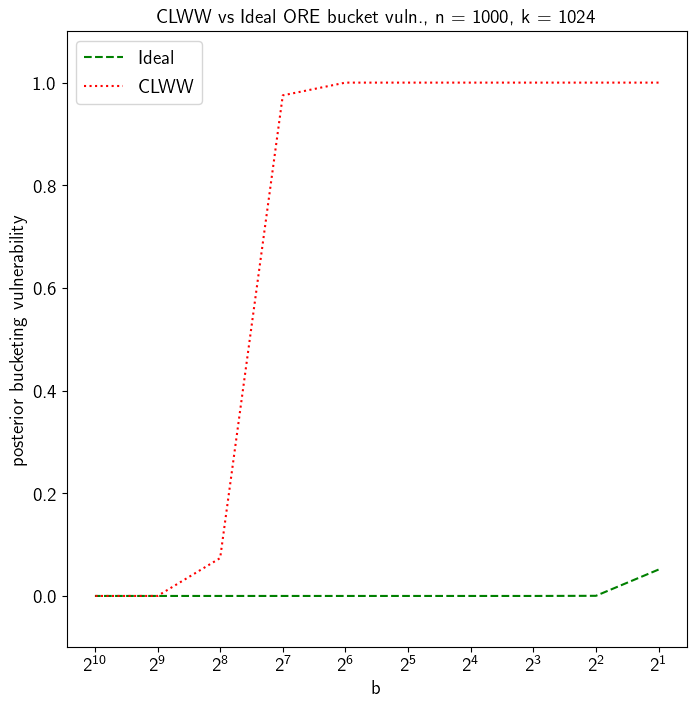

In [30]:
graph_it_bucket(B1k)

### Three line graphs

In [1]:
def df_3line(n_range, k, M): # hardcoded for b = 16, 128, 1024
    n = 0
    n_list = []
    b_list = [16, 128, 1024]
    bit_list = [4, 7, 10] 
    I4_list = []
    I7_list = []
    I10_list = []
    C4_list = []
    C7_list = []
    C10_list = []
    for x in range(n_range):
        n = n + 1
        if n % 20 == 0: print("n : ", n)
        if n % 1000 == 0: gen_df(n_list, I4_list, I7_list, I10_list, C4_list, C7_list, C10_list, n)
        n_list.append(n)
        i4 = big_cat4(n, k, 16)
        I4_list.append(i4)
        i7 = big_cat4(n, k, 128)
        I7_list.append(i7)
        i10 = big_cat4(n, k, 1024)
        I10_list.append(i10)
        c4 = uni_ore_clww_bayes(n, 16, M)  # we plug b in for k for clww bayes
        C4_list.append(c4)
        c7 = uni_ore_clww_bayes(n, 128, M)
        C7_list.append(c7)
        c10 = uni_ore_clww_bayes(n, 1024, M)
        C10_list.append(c10)
    df = gen_df(n_list, I4_list, I7_list, I10_list, C4_list, C7_list, C10_list, n)
    return df

In [2]:
def gen_df(nl, i4l, i7l, i10l, c4l, c7l, c10l, n):
    df = pd.DataFrame(
        {'n':nl,
         'I4':i4l,
         'I7':i7l,
         'I10':i10l,
         'C4':c4l,
         'C7':c7l,
         'C10':c10l
        }
    )
    name = str(n)
    filename = '%s.csv' % name
    df3.to_csv(filename, index = None, header=True)
    return df

### New Params:
k = 128

In [21]:
df3_k128 = pd.read_csv(r'data\128buck2000.csv')

In [26]:
def graph_buck_I128(df):
    ax = plt.figure().gca()
    plt.plot('n', 'I1',
             color='green',
             data=df,
             linestyle='--',
             marker='', 
             label="b = 8")
    plt.plot('n', 'I2', 
             color='red',
             data=df,
             linestyle='dotted',
             marker='', 
             label="b = 32")
    plt.plot('n', 'I3',
             color='blue',
             data=df,
             linestyle='dashed',
             marker='', 
             label="b = 128")
    plt.xlabel('n')
    #plt.xlim(left = 0, right = s_range+1)
    plt.ylabel('posterior bucketing vulnerability')
    plt.ylim(bottom=-.1, top = 1.1)
    plt.title('Ideal ORE, k = 128') #edit to params
    plt.legend(loc='lower right') 
    plt.savefig(r'ore_submission_img\3buck_ideal_128.png')
    plt.show()
    plt.close()

In [30]:
def graph_buck_C128(df):
    ax = plt.figure().gca()
    plt.plot('n', 'C1',
             color='green',
             data=df,
             linestyle='--',
             marker='', 
             label="b = 8")
    plt.plot('n', 'C2',
             color='red',
             data=df,
             linestyle='dotted',
             marker='', 
             label="b = 32")
    plt.plot('n', 'C3',
             color='blue',
             data=df,
             linestyle='dashed',
             marker='', 
             label="b = 128")
    plt.xlabel('n')
    #plt.xlim(left = 0, right = s_range+1)
    plt.ylabel('posterior bucketing vulnerability')
    plt.ylim(bottom=-.1, top = 1.1)
    plt.title('CLWW ORE, k = 128') #edit to params
    plt.legend(loc='lower right') 
    plt.savefig(r'ore_submission_img\3buck_clww_128.png')
    plt.show()
    plt.close()

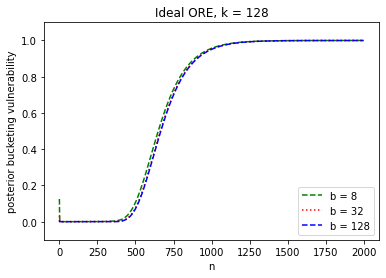

In [31]:
graph_buck_I128(df3_k128)

C:\Users\mirey\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Second argument 'C1' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  
C:\Users\mirey\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: Second argument 'C2' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  
C:\Users\mirey\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: Second argument 'C3' is ambiguous: could be a 

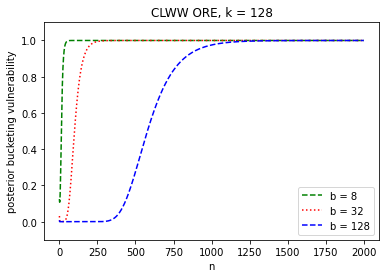

In [32]:
graph_buck_C128(df3_k128)

### Original params:
k = 1024

In [2]:
df3_10k = pd.read_csv(r'data\100back10000.csv')

In [17]:
def graph_buck_I(df):
    ax = plt.figure().gca()
    plt.plot('n', 'I4',
             color='green',
             data=df,
             linestyle='--',
             marker='', 
             label="b = 16")
    plt.plot('n', 'I7', 
             color='red',
             data=df,
             linestyle='dotted',
             marker='', 
             label="b = 128")
    plt.plot('n', 'I10',
             color='blue',
             data=df,
             linestyle='dashed',
             marker='', 
             label="b = 1024")
    plt.xlabel('n')
    #plt.xlim(left = 0, right = s_range+1)
    plt.ylabel('posterior bucketing vulnerability')
    plt.ylim(bottom=-.1, top = 1.1)
    plt.title('Ideal ORE, k = 1024') #edit to params
    plt.legend(loc='lower right') 
    plt.savefig(r'ore_submission_img\3buck_ideal_1024.png')
    plt.show()
    plt.close()

In [18]:
def graph_buck_C(df):
    ax = plt.figure().gca()
    plt.plot('n', 'C4',
             color='green',
             data=df,
             linestyle='--',
             marker='', 
             label="b = 16")
    plt.plot('n', 'C7',
             color='red',
             data=df,
             linestyle='dotted',
             marker='', 
             label="b = 128")
    plt.plot('n', 'C10',
             color='blue',
             data=df,
             linestyle='dashed',
             marker='', 
             label="b = 1024")
    plt.xlabel('n')
    #plt.xlim(left = 0, right = s_range+1)
    plt.ylabel('posterior bucketing vulnerability')
    plt.ylim(bottom=-.1, top = 1.1)
    plt.title('CLWW ORE, k = 1024') #edit to params
    plt.legend(loc='lower right') 
    plt.savefig(r'ore_submission_img\3buck_clww_1024.png')
    plt.show()
    plt.close()

C:\Users\mirey\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Second argument 'C4' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  
C:\Users\mirey\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: Second argument 'C7' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  
C:\Users\mirey\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: Second argument 'C10' is ambiguous: could be a

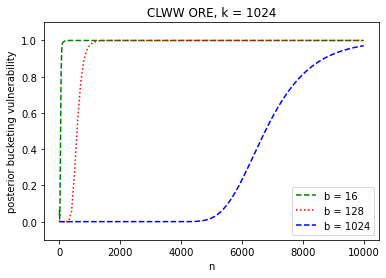

In [19]:
graph_buck_C(df3_10k)

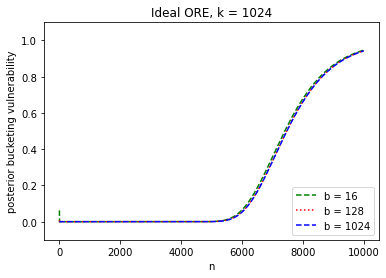

In [20]:
graph_buck_I(df3_10k)

---
### OLD STUFF

OLD  and small values, calcualted manually by Geoff

In [8]:
s_list = [2, 4, 8, 16, 32]
b_list = [1, 2, 3, 4, 5]
Ideal_list = [738481/2097152, 347761/4194304, 48601/8388608, 4501/16777216, 541/33554432]
CLWW_list = []
n = 5
k = 2
clww = uni_ore_clww_bayes(n, k, M)
CLWW_list.append(clww)
k = 4
clww = uni_ore_clww_bayes(n, k, M)
CLWW_list.append(clww)
k = 8
clww = uni_ore_clww_bayes(n, k, M)
CLWW_list.append(clww)
k = 16
clww = uni_ore_clww_bayes(n, k, M)
CLWW_list.append(clww)
k = 32
clww = uni_ore_clww_bayes(n, k, M)
CLWW_list.append(clww)
s_df = pd.DataFrame(
        {'s':s_list,
         'b':b_list, 
         'postIdeal':Ideal_list,
         'postCLWW': CLWW_list
        }
    )

In [9]:
s_df

,s,b,postIdeal,postCLWW
0,2,1,0.3521351814,31/32
1,4,2,0.0829126835,601/1024
2,8,3,0.0057936907,4351/32768
3,16,4,0.0002682805,16801/1048576
4,32,5,0.0000161231,46351/33554432


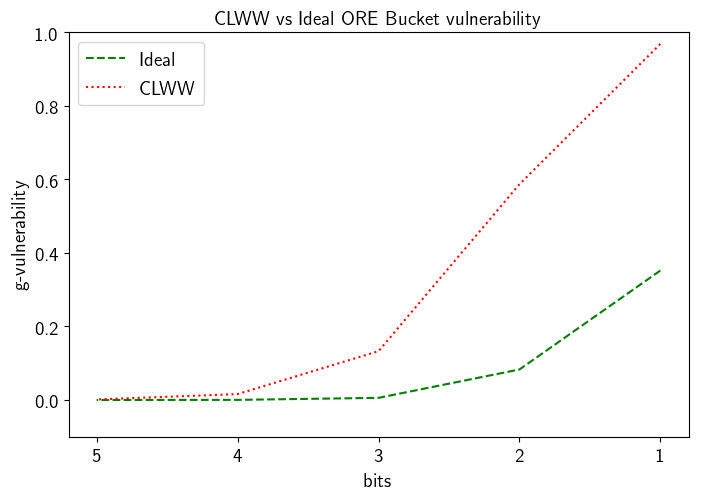

In [11]:
graph_it_bucket(s_df)

### Lower Bound for CLWW

Coupon Adversary vs Bucket adversary

In [12]:
def Harmonic(h):
    i_sum = 0
    for i in range(1, h+1):
        i_sum = i_sum + 1/i
    return i_sum

In [13]:
def b1(n, h):
    val = (h * Harmonic(h))/(n+1)
    if val < 1:
        return 1 - val
    else:
        return 0

In [14]:
M = report_number(1000, 1000)

In [15]:
def df_bounds(n_range, h, k, M): #M is df matrix
    n = 0
    n_list = []
    b1_list = []
    CLWW_list = []
    for x in range(n_range):
        n = n + 1
        n_list.append(n)
        clww = uni_ore_clww_bayes(n, k, M) #only dif
        CLWW_list.append(clww)
        b1v = b1(n,h)
        b1_list.append(b1v)
    df = pd.DataFrame(
        {'n':n_list,
         'CLWW': CLWW_list, 
         'b1_v': b1_list,
        }
    )
    return df

In [16]:
n_range = 1000
h = 32
k = 32
df_bounds = df_bounds(n_range, h, k, M)

In [38]:
def graph_it_clww_bound(n_range, k, df):
    ax = plt.figure().gca()
    plt.plot('n', 'CLWW',
             color='red',
             data=df,
             linestyle='dotted',
             marker='', 
             label="CLWW Bucket")
    plt.plot('n', 'b1_v',
             color='green',
             data=df,
             linestyle='--',
             marker='', 
             label="CLWW Coupon")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel('n')
    plt.xlim(left = 0, right = n_range+1)
    plt.ylabel('g vulnerability')
    plt.ylim(bottom=-.1, top = 1)
    
    plt.title('CLWW Bucket vulnerability, s = {}'.format(k))
    plt.legend(loc='lower right')
    plt.show()
    plt.close()

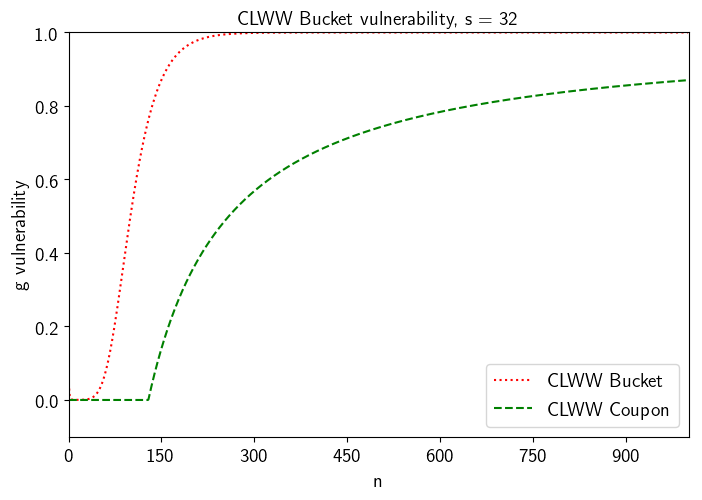

In [39]:
graph_it_clww_bound(n_range, k, df_bounds)

Catuscia's original write up

In [20]:
def g(s, i, h):
    f = math.floor(i/h)
    m = i % h
    left = pow( (scipy.special.comb(s, f+1, exact = True)) / pow(s,(f+1)), m)
    right = pow(((scipy.special.comb(s, f, exact = True))/pow(s,f)), (h-m))
    return left * right

In [33]:
def ideal_bucket_pv(n, h, s):
    prior = 1/pow(h, n)
    v = 0
    for i in range(1, n+1):
        v = v + 1/(pow(s, n-i)) * g(s, i, h) * c_bell(i, n)
    return v * prior

In [25]:
print(ideal_bucket_pv(4, 2, 2))

0.6015625


Catuscia's Upper Bound for Ideal

In [37]:
def old_g(i, h):
    f = math.floor(i/h)
    m = i % h
    return pow((math.factorial(f + 1)), m) * pow(math.factorial(f), (k-m))

In [73]:
def upper(n, h, s):
    i_sum = 0
    for i in range(1, n+1):
        u_sum = 0
        for u in range(0, i+1):
            u_sum = u_sum + pow(-1, (i-u)) * scipy.special.comb(i, u, exact = True) * pow(u, n)
        i_sum = i_sum + ( (1/(pow(s, (n-i)))) * (1/(g(i,h))) * u_sum)
    v = i_sum / (pow(h,n))
    return v

In [59]:
print(upper(4, 4, 2)) # matches 365/2048 per C's code

0.17822265625
